# Goal: investigate code distance required to tolerate ray impact

In [32]:
import sys
sys.path.append('../')

import sinter
import matplotlib.pyplot as plt
import numpy as np
import multiprocess as mp

from stim_surface_code.patch import SurfaceCodePatch
from stim_surface_code.memory import MemoryPatch
from stim_lattice_surgery.lattice_surgery.zxxz_patch import ZXXZPatch
from stim_lattice_surgery.lattice_surgery.glue import GluePatch, BoundaryType
from stim_lattice_surgery.lattice_surgery.surgery_op import SurgeryOp
from ray_delay.noise_model_patch import NoiseModelPatch

In [33]:
dx = 7
dz = 7
dm = 7

patch_control = ZXXZPatch(dx, dz, dm, id_offset=0)
#patch_target = ZXXZPatch(d, d, d, id_offset=2*d**2)
patch_ancilla = ZXXZPatch(dx, dz, dm, id_offset=len(patch_control.all_qubits))

In [34]:
xx_op = SurgeryOp([patch_control, patch_ancilla], [], [(patch_control, BoundaryType.TOP, patch_ancilla, BoundaryType.BOTTOM, len(patch_control.all_qubits) + len(patch_ancilla.all_qubits))])

In [35]:
xx_op.patch_collection

----------------------------------------------------------------------------
|    |    |X146|    |    |    |X147|    |    |    |X148|    |    |    |    |
----------+----+--------------+----+--------------+----+--------------------
|    |  97|    |  98|    |  99|    | 100|    | 101|    | 102|    | 103|    |
----------+----+----+----+----+----+----+----+----+----+----+----+----+-----
|    |    |Z149|    |X150|    |Z151|    |X152|    |Z153|    |X154|    |Z155|
----------+----+----+----+----+----+----+----+----+----+----+----+----+-----
|    | 104|    | 105|    | 106|    | 107|    | 108|    | 109|    | 110|    |
-----+----+----+----+----+----+----+----+----+----+----+----+----+----------
|Z156|    |X157|    |Z158|    |X159|    |Z160|    |X161|    |Z162|    |    |
-----+----+----+----+----+----+----+----+----+----+----+----+----+----------
|    | 111|    | 112|    | 113|    | 114|    | 115|    | 116|    | 117|    |
----------+----+----+----+----+----+----+----+----+----+----+----+----+-----

In [36]:
cosmic_noise = NoiseModelPatch(xx_op.patch_collection)

In [37]:
circ = xx_op.get_stim(init_basis='X', observable_basis='X', expect_bell=True)
result = sinter.collect(tasks=[sinter.Task(circuit=circ)], num_workers=4,
    max_shots=10_000_000,
    max_errors=100,
    decoders=['pymatching'])

In [38]:
result[0].errors / result[0].shots

0.0015281640636938781

In [39]:
dem = circ.detector_error_model(decompose_errors=True, approximate_disjoint_errors=True)

In [40]:
center_qubit_coords = (dx * 2 + 1, dz)
center_qubit = xx_op.patch_collection.device[center_qubit_coords[0]][center_qubit_coords[1]]
center_qubit

197, Coords: (15, 7)

In [41]:
radii = np.arange(1,8).astype(float)
d_range = [7,9,11,13,15,17,19]
init_basis = 'X'
observable_basis = 'X'
tasks = []

def get_task(radius, d):
    patch_control = ZXXZPatch(d, d, d, id_offset=0)
    patch_ancilla = ZXXZPatch(d, d, d, id_offset=len(patch_control.all_qubits))
    xx_op = SurgeryOp([patch_control, patch_ancilla], [], [(patch_control, BoundaryType.TOP, patch_ancilla, BoundaryType.BOTTOM, len(patch_control.all_qubits) + len(patch_ancilla.all_qubits))])
    center_qubit = xx_op.patch_collection.device[d*2+1][d].idx
    cosmic_noise = NoiseModelPatch(xx_op.patch_collection)
    cosmic_noise.force_cosmic_ray(center_qubit, radius)

    circ = xx_op.get_stim(init_basis=init_basis, observable_basis=observable_basis, expect_bell=True)
    return sinter.Task(circuit=circ, json_metadata={'r': radius, 'd': d})

for radius in radii:
    with mp.Pool(6) as pool:
        tasks += pool.starmap(get_task, [(radius, d) for d in d_range])

In [42]:
samples = sinter.collect(
    num_workers=6,
    max_shots=1_000_000,
    max_errors=500,
    tasks=tasks,
    decoders=['pymatching']
)

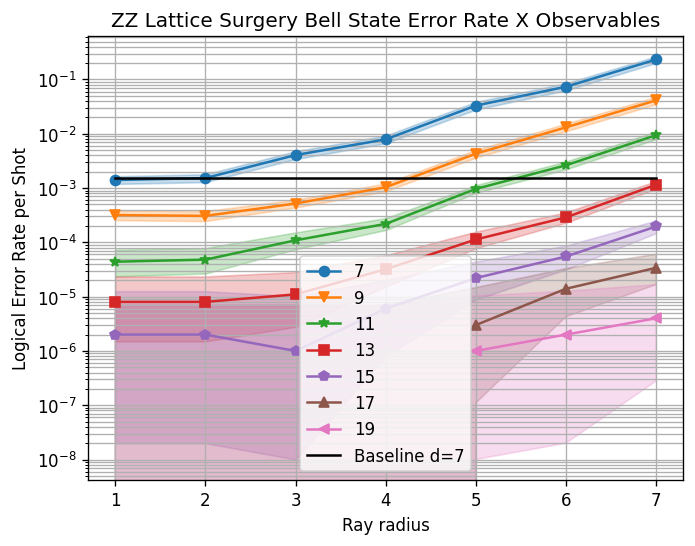

In [43]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: stats.json_metadata['r'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_yscale('log')
ax.set_title(f"ZZ Lattice Surgery Bell State Error Rate {observable_basis} Observables")
ax.set_xlabel("Ray radius")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')

ax.plot(radii, [result[0].errors / result[0].shots for _ in radii], label='Baseline d=7', color='black')

ax.legend()
fig.set_dpi(120)  # Show it bigger